# Assignment

In this assignment, you'll create a Python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: BBC, CBS, CNN, Fox, and New York times.

# Analysis

1. From reviewing the sentiments of the news organizations, it is apparrant that CBS leans towards being positive in it's tweets compared to others. 
2. Fox news has a negative sentiment, though not too negative. This indicates that they have a fairly even distribution of positive, negative, and neutral sentiments. 
3. CBS has a large gap of tweets between its first and last, indicating, that they do not tweet as frequently as the others. This could lead to a skew of CBS leaning towards positive. 

In [1]:
#dependencies
import tweepy #pip install tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone

In [2]:
# YAML stuff
import yaml
TWITTER_CONFIG_FILE = 'auth.yaml'

with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    
# print(type(config))
import json

print(json.dumps(config, indent=4, sort_keys=True))
consumer_key = config['twitter']['consumer_key']
print(consumer_key)

{
    "twitter": {
        "access_token": "942946542209474561-KkJgsxXMBJRE1JkGxHdQw0mblX4Ahht",
        "access_token_secret": "Nf1p8w9xeBJ8kOFCo3hM8MmR6iFBd0Q8XKLTdzfTskf9d",
        "consumer_key": "eVPxS1ESzxNuO2J89vkqRepgw",
        "consumer_secret": "MjrNSnKPLzkxclE3csYavEDEFKzqsSJWAIoZOMGWtzmZF63N3G"
    }
}
eVPxS1ESzxNuO2J89vkqRepgw


In [3]:
#sentiment analyzer #pip install vaderSentiment==2.5
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [4]:
#twitter API keys
consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [5]:
#tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth,parser=tweepy.parsers.JSONParser())

In [6]:
#dictionary of twitter SNs, network names, and colors for graphs
#BBC, CBS, CNN, Fox, and New York times
news_labels = {'BBC': 
                   {'name': 'BBC', 
                    'color': 'lightblue'}, 
               'CBS': 
                   {'name': 'CBS', 
                    'color': 'green'},
               'CNN': 
                   {'name': 'CNN', 
                    'color': 'red'}, 
               'FoxNews': 
                   {'name': 'Fox', 
                    'color': 'blue'},
               'nytimes': 
                   {'name': 'New York Times', 
                    'color': 'yellow'} }

In [7]:
news_dict = {
    "Screen Name": [],
    "Tweet": [],
    "Date": [],
    "Compound Score": [],
    "Positive Score": [],
    "Negative Score": [],
    "Neutral Score": [],
    "Tweets Ago": []
}

In [8]:
# loop through SNs in dictionary
for news_org in news_labels.keys():
    tweets_ago = 1
    for x in range(5): 
        if x == 0:
            response = api.user_timeline(news_org, count = 20)
        else:
            response = api.user_timeline(news_org, max_id = end_id-1 , count = 20)
        for tweet in response: 
            text = tweet['text']
            date = tweet['created_at']
            convert_date = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y") 
            user = tweet['user']['screen_name'] 
            end_id = tweet['id'] 
            scores = analyzer.polarity_scores(text) 
            news_dict['Screen Name'].append(user)
            news_dict['Tweet'].append(text)
            news_dict['Date'].append(convert_date) 
            news_dict['Compound Score'].append(scores['compound']) 
            news_dict['Positive Score'].append(scores['pos'])
            news_dict['Negative Score'].append(scores['neg'])
            news_dict['Neutral Score'].append(scores['neu'])
            news_dict['Tweets Ago'].append(tweets_ago)
            tweets_ago = tweets_ago + 1 

In [9]:
#converts to dataframe
news_df = pd.DataFrame(news_dict)
news_df.head()

,Compound Score,Date,Negative Score,Neutral Score,Positive Score,Screen Name,Tweet,Tweets Ago
0,0.2960,2018-01-08 21:29:44+00:00,0.000,0.905,0.095,BBC,RT @bbc5live: Looking for some exercise and nu...,1
1,0.0000,2018-01-08 21:29:01+00:00,0.000,1.000,0.000,BBC,RT @bbcasiannetwork: 📡 The Asian Network Futur...,2
2,-0.1655,2018-01-08 21:28:07+00:00,0.099,0.831,0.069,BBC,RT @bbcthesocial: Jordan thought nobody would ...,3
3,0.3182,2018-01-08 21:27:12+00:00,0.000,0.905,0.095,BBC,"RT @bbcworldservice: ""Our job as journalists i...",4
4,-0.2500,2018-01-08 21:23:06+00:00,0.118,0.882,0.000,BBC,RT @BBCiPlayer: 🎁 #HardSun is the new #boxset ...,5


In [10]:
news_df.to_csv('output/news_analysis.csv')

In [11]:
#group the dataframe values by network name 
by_org = news_df.groupby('Screen Name')

pos_count = news_df[news_df['Compound Score'] > 0].groupby('Screen Name')['Compound Score'].count()
neg_count = news_df[news_df['Compound Score'] < 0].groupby('Screen Name')['Compound Score'].count()
neu_count = news_df[news_df['Compound Score'] == 0].groupby('Screen Name')['Compound Score'].count()

polarity_df = pd.DataFrame({
    "Positive Compound Scores": pos_count,
    "Negative Compound Scores": neg_count,
    "Neutral Compound Scores": neu_count,
    "Total": pos_count + neg_count + neu_count
})
polarity_df

,Negative Compound Scores,Neutral Compound Scores,Positive Compound Scores,Total
Screen Name,,,,
BBC,18,46,36,100
CBS,8,27,65,100
CNN,20,44,36,100
FoxNews,32,32,36,100
nytimes,30,41,29,100


In [12]:
neg_sum = polarity_df['Negative Compound Scores'].sum()
neu_sum = polarity_df['Neutral Compound Scores'].sum()
pos_sum = polarity_df['Positive Compound Scores'].sum()
total = neg_sum + pos_sum + neu_sum

totals_df = pd.DataFrame({
    "Total Negative": [neg_sum],
    "Total Positive": pos_sum,
    "Total Neutral": neg_sum,
    "Total": total
})

totals_df

,Total,Total Negative,Total Neutral,Total Positive
0,500,108,108,202


In [13]:
time_max = by_org['Date'].max()
time_min = by_org['Date'].min()
time_diff = time_max - time_min
time_diff

avg_time_bt_tweets = time_diff/100
time_df = pd.DataFrame({
    "Time Span Between 1 and 100 Tweets Ago": time_diff,
    "Average Time Between Tweets": avg_time_bt_tweets
})

time_df

,Average Time Between Tweets,Time Span Between 1 and 100 Tweets Ago
Screen Name,,
BBC,00:30:17.200000,2 days 02:28:40
CBS,06:54:47.510000,28 days 19:19:11
CNN,00:07:51.860000,0 days 13:06:26
FoxNews,00:04:52.280000,0 days 08:07:08
nytimes,00:12:25.160000,0 days 20:41:56


In [14]:
#finds date of most recent and least recent tweet
date_max = news_df['Date'].max().replace(tzinfo=timezone.utc).astimezone(tz = 'America/Los_Angeles').strftime('%D: %r')
date_min = date_min = news_df['Date'].min().replace(tzinfo=timezone.utc).astimezone(tz = 'America/Los_Angeles').strftime('%D: %r')

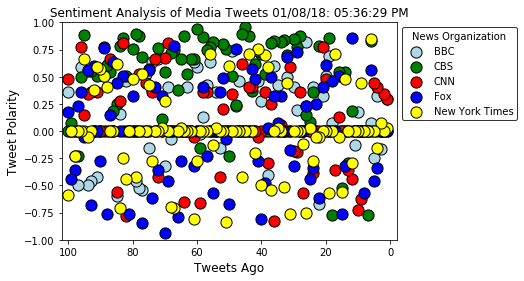

In [18]:
#plots scatter of news organizations in dictionary

plt.xlim(102,-2, -1)
plt.ylim(-1,1)
plt.title('Sentiment Analysis of Media Tweets %s' % (date_max), fontdict = {'fontsize': 12})

for news_org in news_labels.keys():
    df = news_df[news_df['Screen Name'] == news_org]
    yvals = df['Compound Score']
    xvals = df['Tweets Ago']
    labels = news_labels[news_org]['name']
    colors = news_labels[news_org]['color'] 
    plt.scatter(xvals,yvals, label = labels, s = 125, color = colors, edgecolor = 'black')
    
plt.legend(bbox_to_anchor = (1,1),
           frameon = True, 
           edgecolor = 'black', 
           facecolor = 'white',
           title = "News Organization")
plt.xlabel('Tweets Ago',
          fontdict = {'fontsize': 12})
plt.ylabel('Tweet Polarity',
          fontdict = {'fontsize': 12})
plt.savefig('output/tweets_scatter.png', bbox_inches = 'tight')
plt.show()

In [19]:
# group by SN and find average of each group
scores_by_org = news_df.groupby('Screen Name')['Compound Score'].mean()
scores_by_org.head()

Screen Name
BBC        0.091436
CBS        0.378797
CNN        0.072377
FoxNews    0.009852
nytimes    0.003912
Name: Compound Score, dtype: float64

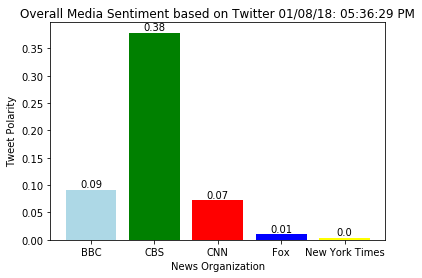

In [20]:

# bar chart of mean scores labels
plt.title('Overall Media Sentiment based on Twitter %s' % (date_max))
plt.xlabel('News Organization')
plt.ylabel('Tweet Polarity')

xlabels = scores_by_org.index
xvals = np.arange(len(scores_by_org))
count = 0 

#create each value label
for score in scores_by_org: 
    if score < 0: 
        height = score - .01
    else: 
        height = score + .01
    plt.text(count, height, str(round(score, 2)), ha = 'center', va = 'center')
    count = count + 1
plt.bar(xvals, 
        scores_by_org, 
        color = [news_labels[x]['color'] for x in xlabels], 
        tick_label = [news_labels[x]['name'] for x in xlabels]) 
plt.savefig('output/average_scores.png')
plt.show()